# GNN runner
## Mark Tenzer & Jimmy Howerton
## Adapted from code provided with the Spektral package, cited below:
https://github.com/danielegrattarola/spektral/blob/master/examples/node_prediction/citation_gcn.py


# Imports

In [32]:
# Base python
import pickle # for loading sparse matrix from disk
import gc     # for garbage collection (RAM management/cleanup)

# Common scientific packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import math

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

# TF imports
from tensorflow.keras.callbacks import EarlyStopping,CSVLogger, LearningRateScheduler, Callback, ModelCheckpoint
from tensorflow.keras.layers import Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import tensorflow as tf
# Spektral imports for GNN
from spektral.layers import GraphConv, GraphSageConv, GINConv
from collections import Counter

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


# Config

In [3]:
# Type of graph convolution
subset_2015 = True

# is the data/adjacency matrix sorted?
is_sorted = False

#type of model to be run
modelType = 'SAGE' # GIN, GCN, SAGE

#location of saved adjacency matrices
adjLoc = "adj/"

#location of saved data
dataLoc = "data/"

#location of saved models
modelLoc = "models/"

# Number of graph convolution layers
n_layers = 5

# Number of channels at each conv
channels = 64

# Maximum number of training epochs
epochs = 1000

# Dropout rate
# dropout_rate = 0.5


In [4]:
if modelType == 'GCN':
    Conv = GraphConv
elif modelType == 'SAGE':
    Conv = GraphSageConv
elif modelType == 'GIN':
    Conv = GINConv
else:
    raise NameError("specify modelType as 'GCN', 'SAGE', or 'GIN'")

if subset_2015:
    postfix_time = "15"
else:
    postfix_time = "ALL"

if is_sorted:
    postfix_sort = "SORTED"
else:
    postfix_sort = "UNSORTED"

modelfile = modelLoc+"{}_{}_{}.h5".format(modelType,postfix_time,postfix_sort)
# Adjacency matrix and data of choice        

data_path = './'+dataLoc+postfix_time+'/'+postfix_sort+'/'

In [5]:
adj_file = adjLoc+"A_{}_{}_FINAL.pkl".format(postfix_time,postfix_sort)
X = np.array(pd.read_csv(data_path+'Wildfire_Data_X_{}_{}.csv'.format(postfix_time,postfix_sort),index_col='Unnamed: 0'))
Y = np.array(pd.read_csv(data_path+'Wildfire_Data_Y_{}_{}.csv'.format(postfix_time,postfix_sort),index_col='Unnamed: 0'))
train_mask = pd.read_csv(data_path+'train_mask_{}_{}.csv'.format(postfix_time,postfix_sort),index_col='Unnamed: 0',squeeze=True).to_numpy()
val_mask = pd.read_csv(data_path+'val_mask_{}_{}.csv'.format(postfix_time,postfix_sort),index_col='Unnamed: 0',squeeze=True).to_numpy()
test_mask = pd.read_csv(data_path+'test_mask_{}_{}.csv'.format(postfix_time,postfix_sort),index_col='Unnamed: 0',squeeze=True).to_numpy()

n_classes = Y.shape[1]
# Number of examples
N = X.shape[0]
# Number of features
F = X.shape[1]


# Read the adjacency matrix $A$

#### Load $A$ from disk

In [6]:
with open(adj_file, 'rb') as f:
    A = pickle.load(f)

#### Preprocess $A$ as needed for this GNN convolution technique

In [7]:
fltr = Conv.preprocess(A.astype('float32'))

# Define the model

In [8]:

# Input
X_in = Input(shape=(F, ))           # features  for this node
fltr_in = Input((N, ), sparse=True) # adjacency for this node

currentX = X_in

### Model definition

In [11]:
for _ in range(n_layers - 1):

    currentX = Conv(channels,
                      activation='relu',aggregate_op = 'max'
                      #kernel_regularizer=l2(0.1),
                      #use_bias=False
                     )([currentX, fltr_in])
output = Conv(n_classes,
              activation='softmax',aggregate_op = 'max'
              #use_bias=False
             )([currentX, fltr_in])

### Model setup

Learning Rate Decay: https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1

This is only recommended for GIN models

In [33]:
def step_decay(epoch):
   initial_lrate = 1e-2
   drop = 0.5
   epochs_drop = 50.0
   lrate = initial_lrate * math.pow(drop,  
           math.floor((1+epoch)/epochs_drop))
   return lrate
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
       self.losses = []
       self.lr = []
 
    def on_epoch_end(self, batch, logs={}):
       self.losses.append(logs.get('loss'))
       self.lr.append(step_decay(len(self.losses)))

checkpoint = ModelCheckpoint(modelfile, monitor='loss', verbose=1,
    save_best_only=True, mode='auto', save_freq='epoch')

csv_log = CSVLogger(modelLoc+"/logs/{}_{}_{}.log".format(modelType,postfix_time,postfix_sort))
    
callbacks_list = [checkpoint,csv_log]
if modelType == 'GIN':
    loss_history = LossHistory()
    lrate = LearningRateScheduler(step_decay)
    callbacks_list.append(loss_history, lrate)

In [34]:
# Build model
model = Model(inputs=[X_in, fltr_in], outputs=output)
model.compile(optimizer=Adam(1e-2),
              loss='categorical_crossentropy',
              weighted_metrics=['categorical_accuracy'])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 83)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
graph_sage_conv_1 (GraphSageCon (None, 64)           10688       input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
graph_sage_conv_2 (GraphSageCon (None, 64)           8256        graph_sage_conv_1[0][0]    

# Model fitting

In [30]:
#model.load_weights(modelfile)

In [ ]:
# Define validation data
if modelType == 'SAGE':
    bs = N
else:
    bs = N

validation_data = ([X, fltr], Y, val_mask)
history = model.fit([X, fltr],
          Y,
          sample_weight=train_mask,
          epochs=10000,
          batch_size=bs,
          validation_data=validation_data,
          shuffle=False,callbacks=callbacks_list)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 74491 samples, validate on 74491 samples
Epoch 1/10000


/home/jh3df/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jh3df/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jh3df/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/jh3df/.local/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:43


Epoch 00001: loss improved from inf to 1.02095, saving model to models/FINAL/SAGE_15_UNSORTED.h5
74491/74491 [==============================] - 7s 98us/sample - loss: 1.0209 - categorical_accuracy: 0.6141 - val_loss: 0.1474 - val_categorical_accuracy: 0.1353
Epoch 2/10000

Epoch 00002: loss did not improve from 1.02095
74491/74491 [==============================] - 4s 58us/sample - loss: 1.3188 - categorical_accuracy: 0.1450 - val_loss: 0.1311 - val_categorical_accuracy: 0.3442
Epoch 3/10000

Epoch 00003: loss did not improve from 1.02095
74491/74491 [==============================] - 4s 57us/sample - loss: 1.1743 - categorical_accuracy: 0.3446 - val_loss: 0.1262 - val_categorical_accuracy: 0.4174
Epoch 4/10000

Epoch 00004: loss did not improve from 1.02095
74491/74491 [==============================] - 5s 66us/sample - loss: 1.1317 - categorical_accuracy: 0.4242 - val_loss: 0.1243 - val_categorical_accuracy: 0.4331
Epoch 5/10000

Epoch 00005: loss did not improve from 1.02095
74491/

In [31]:
gc.collect()

42

# Plot training history

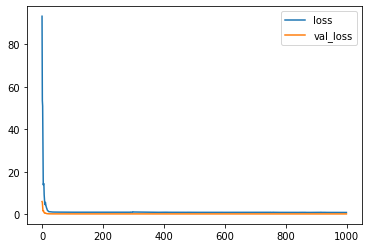

In [32]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='loss')
ax.plot(history.history['val_loss'], label='val_loss')
ax.legend()
plt.show()

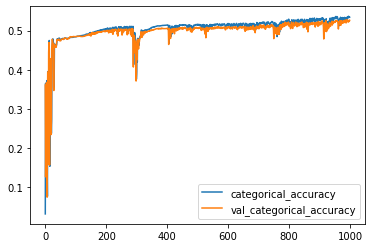

In [33]:
fig, ax = plt.subplots()
ax.plot(history.history['categorical_accuracy'], label='categorical_accuracy')
ax.plot(history.history['val_categorical_accuracy'], label='val_categorical_accuracy')
ax.legend()
plt.show()

Show learning rate for GIN models

In [34]:
# plt.plot(loss_history.lr)

# Evaluate Model

In [35]:
eval_results = model.evaluate([X, fltr],
                              Y,
                              sample_weight=test_mask,
                              batch_size=N)

  ...
    to  
  ['...']
74491/74491 [==============================] - 0s 5us/sample - loss: 0.0944 - categorical_accuracy: 0.5427


# Process Data

In [6]:
data = pd.read_csv(dataLoc+'fires_merged_weather.csv', index_col=0,
                  #dtype for smaller representation
                  dtype={#'STAT_CAUSE_DESCR': 'category', 'STATE': 'category', 'DISCOVERY_MONTH': 'category',
                        'Fog': 'bool', 'FunnelCloud': 'bool', 'Hail': 'bool', 'Rain': 'bool',
                        'Snow': 'bool', 'Thunder': 'bool'}
                  )
#data['DAY'] = (data['FIRE_YEAR']-1992)*365+data['DISCOVERY_DOY']

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


#### Drop unnecessary columns

In [7]:
if is_sorted:
    data['DAY'] = (data['FIRE_YEAR']-1992)*365+data['DISCOVERY_DOY']
    data = data.sort_values('DAY', ascending=True, kind='mergesort')
    data.drop('DAY', axis='columns', inplace=True)
data.drop(['Unnamed: 0.1', 'index_x', 'FOD_ID', 'FIRE_NAME', 'DISCOVERY_DOY_SCALED',
           'x_fire', 'y_fire', 'z_fire',
           'index_y', 'Begin', 'End', 'Country', 'Day', 'ICAO', 'Latitude', 'Longitude', 'Month', 'STATION NAME',
           'State', 'Station', 'USAF', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1', 
           'WBAN', 'Year', 'doy', 'x', 'y', 'z'
          ],
         axis='columns', inplace=True)


#### Sorting so that adjacency matrix is aligned with rows

#### Cleanup memory

In [8]:
gc.collect()

47

In [9]:
if subset_2015:
    data_full = data
    data = data[data['FIRE_YEAR']==2015]

In [16]:
data = data[-data.shape[0]//2:-1]

# Preprocess the data

Perform imputation as appropriate; split into train/validation sets.

#### Split into features and labels

In [17]:
Y = pd.get_dummies(data['STAT_CAUSE_DESCR'])
X = pd.get_dummies(data.drop('STAT_CAUSE_DESCR', axis='columns'))

# Number of examples
N = X.shape[0]
# Number of features
F = X.shape[1]

#### Find the missing values, and set to NA

In [18]:
for na in [9999.9, 999.9, 99.99]:
    X[X == na] = np.nan

#### Zero-imputing for some features -- see EDA.ipynb

In [19]:
for zcol in ['Gust', 'MaxWindspeed', 'Precip', 'SnowDepth', 'Visibility', 'Windspeed']:
    X.loc[X[zcol].isna(), zcol] = 0

# Split into training/validation/testing

We'll have three sets of nodes: training nodes, validation nodes, and censored nodes (nodes without valid labels).  Note that this is a semi-supervised problem.

#### Determine which nodes lack valid labels

In [20]:
# Determing which fires fit in these categories
censor = (data['STAT_CAUSE_DESCR'] == 'Missing/Undefined') | (data['STAT_CAUSE_DESCR'] == 'Miscellaneous')

# Drop these levels from the label
Y = Y.drop(['Missing/Undefined', 'Miscellaneous'], axis='columns').values

# Number of classes left
n_classes = Y.shape[1]

In [21]:
labeled_ind  = np.arange(data.shape[0])[~censor]
censor_ind = np.arange(data.shape[0])[censor ]

#### Determine which nodes lack valid labels

In [22]:
 train_ind, test_ind = train_test_split(labeled_ind, test_size=0.1, random_state=42)

 train_ind, val_ind = train_test_split(train_ind, test_size=0.1, random_state=42)

# "Masks" for training and validation: 1 if in the given set, 0 if not (or no label)
train_mask = np.zeros(N)
train_mask[train_ind] = 1

test_mask = np.zeros(N)
test_mask[test_ind] = 1

val_mask = np.zeros(N)
val_mask[val_ind] = 1

#### Mean imputation for the other features -- see EDA.ipynb

In [23]:
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

In [24]:
# Make sure to fit only on the training data!  Otherwise the imputation introduces bias
imp.fit(X.values[train_ind, :])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='mean', verbose=0)

In [25]:
# Impute the training and testing values
X = imp.transform(X)

In [79]:
pd.DataFrame(X).to_csv(data_path+'Wildfire_Data_X_{}_{}.csv'.format(postfix_time,postfix_sort))
pd.DataFrame(Y).to_csv(data_path+'Wildfire_Data_Y_{}_{}.csv'.format(postfix_time,postfix_sort))
pd.DataFrame(train_mask).to_csv(data_path+'train_mask_{}_{}.csv'.format(postfix_time,postfix_sort))
pd.DataFrame(val_mask).to_csv(data_path+'val_mask_{}_{}.csv'.format(postfix_time,postfix_sort))
pd.DataFrame(test_mask).to_csv(data_path+'test_mask_{}_{}.csv'.format(postfix_time,postfix_sort))

In [26]:
pd.DataFrame(X).to_csv(data_path+'Wildfire_Data_X_{}_{}_HALF.csv'.format(postfix_time,postfix_sort))
pd.DataFrame(Y).to_csv(data_path+'Wildfire_Data_Y_{}_{}_HALF.csv'.format(postfix_time,postfix_sort))
pd.DataFrame(train_mask).to_csv(data_path+'train_mask_{}_{}_HALF.csv'.format(postfix_time,postfix_sort))
pd.DataFrame(val_mask).to_csv(data_path+'val_mask_{}_{}_HALF.csv'.format(postfix_time,postfix_sort))
pd.DataFrame(test_mask).to_csv(data_path+'test_mask_{}_{}_HALF.csv'.format(postfix_time,postfix_sort))